In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import datetime
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn import metrics
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit, TimeSeriesSplit
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, make_scorer, roc_curve


sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# **Pre**

In [ ]:
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE, MAX_ROWS=300000):

    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    num_rows = 0
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        num_rows += len(df)
        if num_rows >= MAX_ROWS:
            break
    df_final = pd.concat(frames)

    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data
    df_final=df_final.replace([-1],0)

    return df_final

In [ ]:
DIR_INPUT='/content/drive/MyDrive/Tesis/Final_3/'

BEGIN_DATE = "2023-01-01"
END_DATE = "2023-05-31"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.CARDING.sum()))

Load  files
CPU times: user 369 ms, sys: 355 ms, total: 724 ms
Wall time: 19.7 s
303868 transactions loaded, containing 178 fraudulent transactions


In [ ]:
n_folds = 4

Taking into account only 10 features

In [ ]:
output_feature="CARDING"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'WEB_ID']

In [ ]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])

    return (train,test)

# Modelo

## LR 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_df[input_features],
                                                        transactions_df[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0008611650697010961
Average Recall: 0.827517162471396


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60738 ocurrencias
Clase 1: 36 ocurrencias
Longitud test set:  60774


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 40740 ocurrencias
Clase 1: 20034 ocurrencias
Longitud test set:  60774


In [ ]:
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.001397624039133473
Test Recall: 0.7777777777777778
Test CM: [[40732 20006]
 [    8    28]]
THRESHOLD:  0.1
Test Precision: 0.000782700091687725
Test Recall: 0.9722222222222222
Test CM: [[16056 44682]
 [    1    35]]
THRESHOLD:  0.05
Test Precision: 0.0006980872409597703
Test Recall: 0.9722222222222222
Test CM: [[10636 50102]
 [    1    35]]
THRESHOLD:  0.01
Test Precision: 0.000632688927943761
Test Recall: 1.0
Test CM: [[ 3874 56864]
 [    0    36]]
THRESHOLD:  0.005
Test Precision: 0.0006161324000068459
Test Recall: 1.0
Test CM: [[ 2345 58393]
 [    0    36]]
THRESHOLD:  0.001
Test Precision: 0.0005988621618924045
Test Recall: 1.0
Test CM: [[  660 60078]
 [    0    36]]


<ipython-input-93-7a89c2d48c8d>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


60398
0.9018596386318285


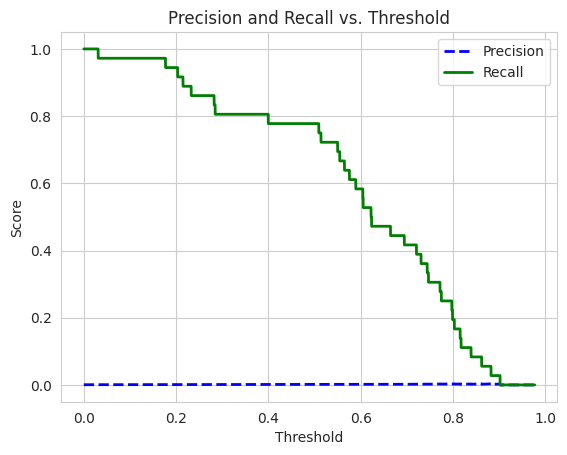

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

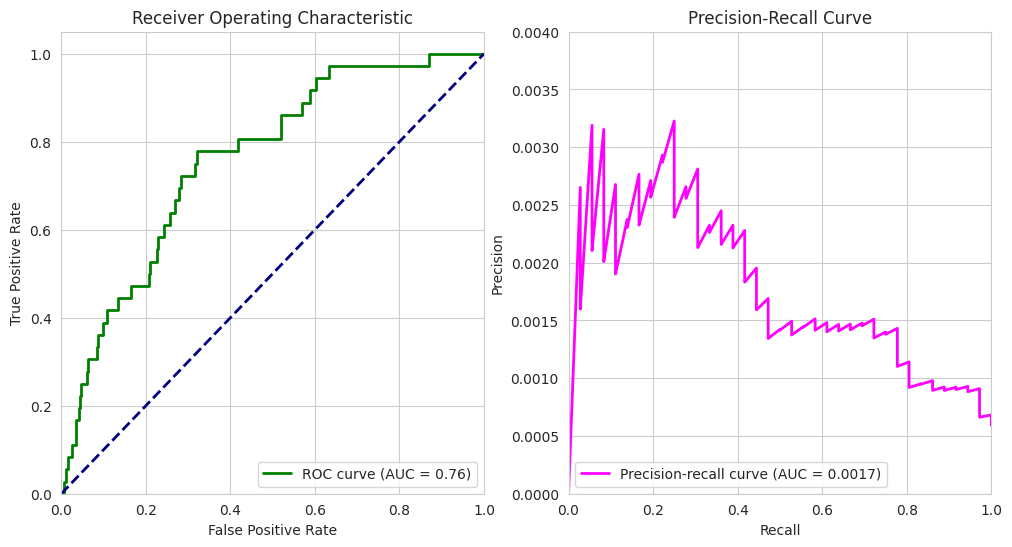

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.4f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 0.004])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## DT 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_df[input_features],
                                                        transactions_df[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4, random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0010319942761520963
Average Recall: 0.7572463768115942


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60738 ocurrencias
Clase 1: 36 ocurrencias
Longitud test set:  60774


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 41187 ocurrencias
Clase 1: 19587 ocurrencias
Longitud test set:  60774


In [ ]:
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.0014805738500025527
Test Recall: 0.8055555555555556
Test CM: [[41180 19558]
 [    7    29]]
THRESHOLD:  0.1
Test Precision: 0.0010944682447856407
Test Recall: 0.9722222222222222
Test CM: [[28794 31944]
 [    1    35]]
THRESHOLD:  0.05
Test Precision: 0.0010415736690176473
Test Recall: 0.9722222222222222
Test CM: [[27170 33568]
 [    1    35]]
THRESHOLD:  0.01
Test Precision: 0.0009384887649487853
Test Recall: 0.9722222222222222
Test CM: [[23479 37259]
 [    1    35]]
THRESHOLD:  0.005
Test Precision: 0.0009384887649487853
Test Recall: 0.9722222222222222
Test CM: [[23479 37259]
 [    1    35]]
THRESHOLD:  0.001
Test Precision: 0.0009384887649487853
Test Recall: 0.9722222222222222
Test CM: [[23479 37259]
 [    1    35]]


<ipython-input-105-7a89c2d48c8d>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


11
1.0


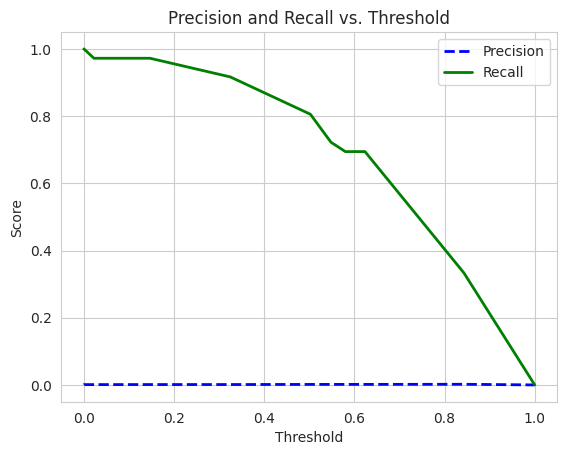

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

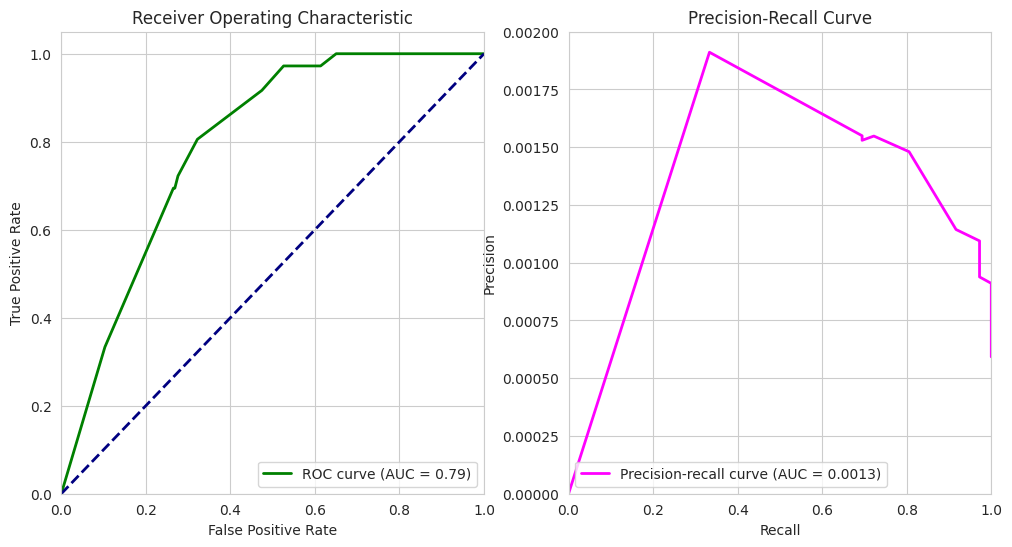

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.4f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 0.002])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## RF 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_df[input_features],
                                                        transactions_df[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0023756518157998993
Average Recall: 0.25427154843630817


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60738 ocurrencias
Clase 1: 36 ocurrencias
Longitud test set:  60774


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60773 ocurrencias
Clase 1: 1 ocurrencias
Longitud test set:  60774


In [ ]:
thresholds = [0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.0
Test Recall: 0.0
Test CM: [[60737     1]
 [   36     0]]
THRESHOLD:  0.25
Test Precision: 0.0
Test Recall: 0.0
Test CM: [[60717    21]
 [   36     0]]
THRESHOLD:  0.1
Test Precision: 0.004975124378109453
Test Recall: 0.027777777777777776
Test CM: [[60538   200]
 [   35     1]]
THRESHOLD:  0.05
Test Precision: 0.0037313432835820895
Test Recall: 0.08333333333333333
Test CM: [[59937   801]
 [   33     3]]
THRESHOLD:  0.01
Test Precision: 0.0020408163265306124
Test Recall: 0.4722222222222222
Test CM: [[52425  8313]
 [   19    17]]
THRESHOLD:  0.005
Test Precision: 0.0020408163265306124
Test Recall: 0.4722222222222222
Test CM: [[52425  8313]
 [   19    17]]
THRESHOLD:  0.001
Test Precision: 0.0020408163265306124
Test Recall: 0.4722222222222222
Test CM: [[52425  8313]
 [   19    17]]


14
0.14


<ipython-input-117-7a89c2d48c8d>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


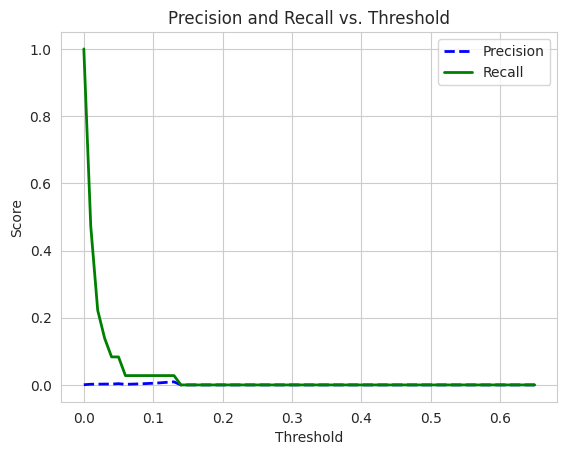

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

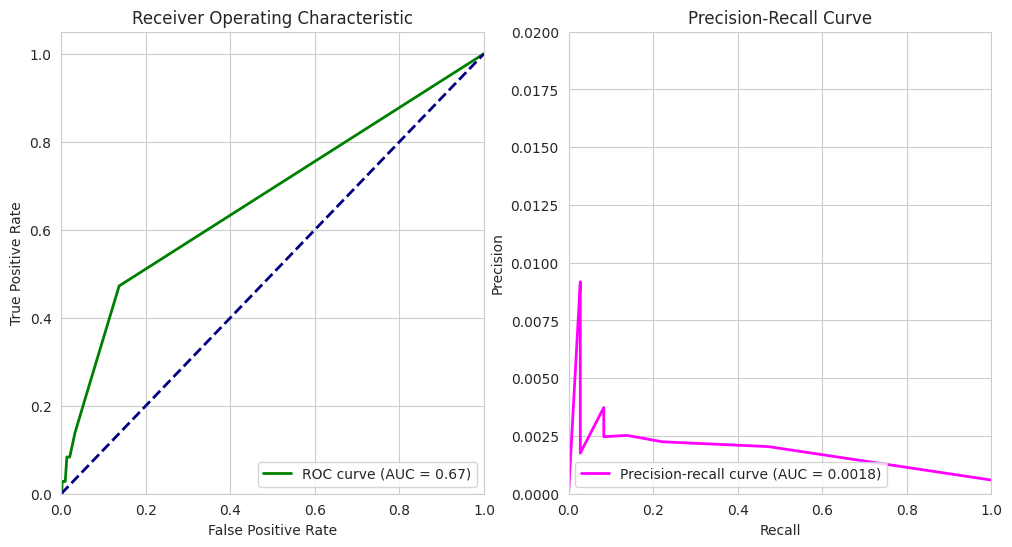

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.4f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 0.02])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")